In [334]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('../data/Eviction_Notices.csv')

#print the head
df.head()


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,DELETE - Neighborhoods,DELETE - Police Districts,DELETE - Supervisor Districts,DELETE - Fire Prevention Districts,DELETE - Zip Codes,"CBD, BID and GBD Boundaries as of 2017",Central Market/Tenderloin Boundary,"Areas of Vulnerability, 2016",Central Market/Tenderloin Boundary Polygon - Updated,Fix It Zones as of 2018-02-07
0,M200260,2800 Block Of 24th Street,San Francisco,CA,94110,02/12/2020,False,False,False,False,...,19.0,4.0,7.0,2.0,28859.0,NaN,NaN,1.0,NaN,NaN
1,M200159,400 Block Of Fillmore Street,San Francisco,CA,94117,01/28/2020,True,False,False,False,...,10.0,9.0,11.0,15.0,29492.0,NaN,NaN,1.0,NaN,NaN
2,M200271,700 Block Of Wisconsin Street,San Francisco,CA,94107,02/11/2020,False,False,False,False,...,29.0,3.0,8.0,10.0,28856.0,NaN,NaN,1.0,NaN,NaN
3,M200202,300 Block Of Serrano Drive,San Francisco,CA,94132,02/05/2020,False,True,False,False,...,14.0,8.0,4.0,1.0,64.0,NaN,NaN,2.0,NaN,NaN
4,M200169,2300 Block Of 25th Avenue,San Francisco,CA,94116,01/21/2020,False,False,False,False,...,35.0,8.0,3.0,1.0,29491.0,NaN,NaN,1.0,NaN,24.0


File Date
1997-01-02    10
1997-01-03     8
1997-01-06    14
1997-01-07     4
1997-01-08    14
              ..
2020-04-01     2
2020-04-02     1
2020-04-03     7
2020-04-06     2
2020-04-08     2
Name: Eviction ID, Length: 5740, dtype: int64


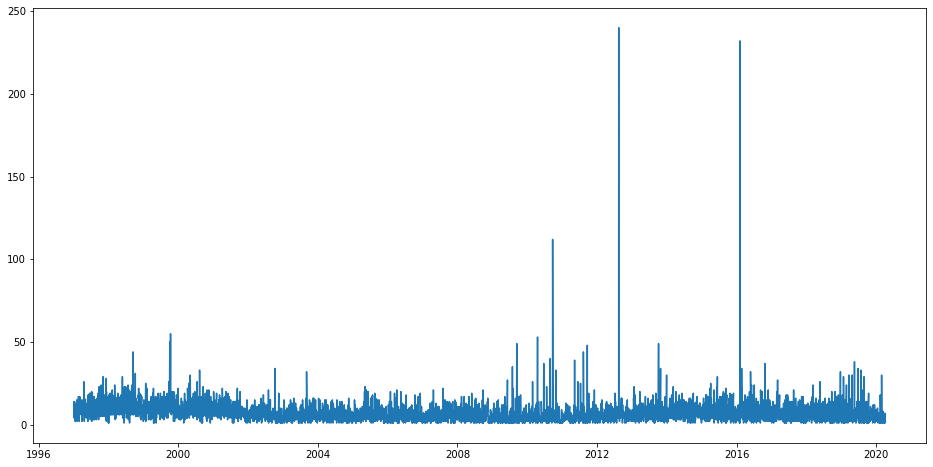

In [335]:
#setting index as date
df['File Date'] = pd.to_datetime(df["File Date"])
df.index = df['File Date']

#plot
plt.figure(figsize=(16,8))

#Group evictions by day
df.index.name = None
evictedByDay = df.groupby('File Date')['Eviction ID'].count()

print(evictedByDay)
df.index = df['File Date']

#Find halfway point to train data
halfway_point = len(evictedByDay)//2

plt.plot(evictedByDay, label='Number of Evictions')

In [336]:
#setting index as date values
df['File Date'] = pd.to_datetime(df["File Date"])
df.index = df['File Date']

#sorting
data = evictedByDay.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(evictedByDay)),columns=['Date', 'Evicted'])

evictedByDay.index = pd.to_datetime(evictedByDay.index)

for i in range(0,len(data)):
    new_data['Date'][i] = evictedByDay.index[i]
    new_data['Evicted'][i] = evictedByDay[i]

In [337]:
#create features
from fastai.tabular import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

In [338]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [339]:
#split into train and validation
train = new_data[:halfway_point]
valid = new_data[halfway_point:]

x_train = train.drop('Evicted', axis=1)
y_train = train['Evicted']
x_valid = valid.drop('Evicted', axis=1)
y_valid = valid['Evicted']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [340]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

10.106685884579262

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


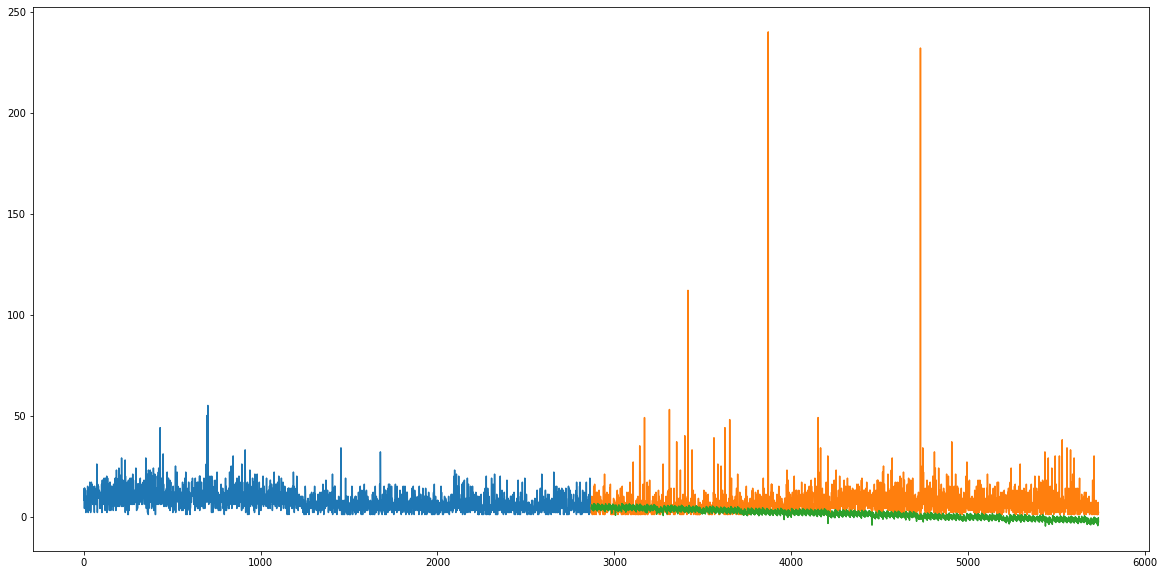

In [341]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[halfway_point:].index
train.index = new_data[:halfway_point].index

plt.plot(train['Evicted'])
plt.plot(valid[['Evicted', 'Predictions']])

In [342]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [343]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [344]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

8.73649982639921

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


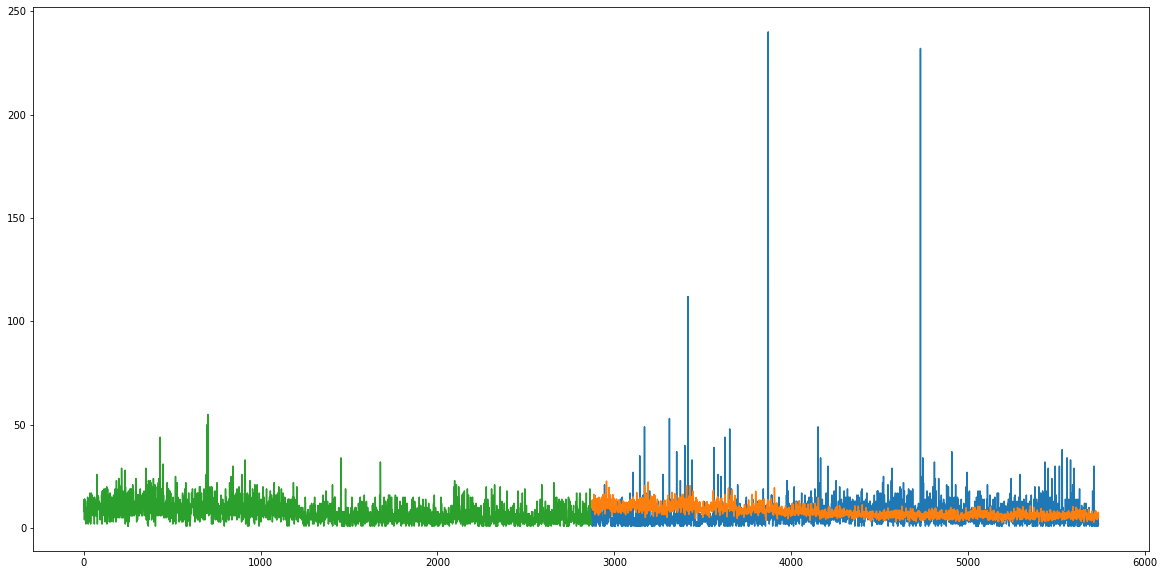

In [345]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Evicted', 'Predictions']])
plt.plot(train['Evicted'])

In [346]:
from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = evictedByDay[:halfway_point]
valid = evictedByDay[halfway_point:]

training = train
validation = valid

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=halfway_point)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=16733.941, BIC=16763.729, Time=23.350 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=20360.602, BIC=20372.517, Time=0.257 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=18814.691, BIC=18838.521, Time=3.855 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=16734.911, BIC=16758.742, Time=12.921 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=20358.602, BIC=20364.559, Time=0.197 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=18556.501, BIC=18580.331, Time=8.673 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=16734.832, BIC=1

In [347]:
rms=np.sqrt(np.mean(np.power((np.array(valid)-np.array(forecast['Prediction'])),2)))
rms

10.375236406186058

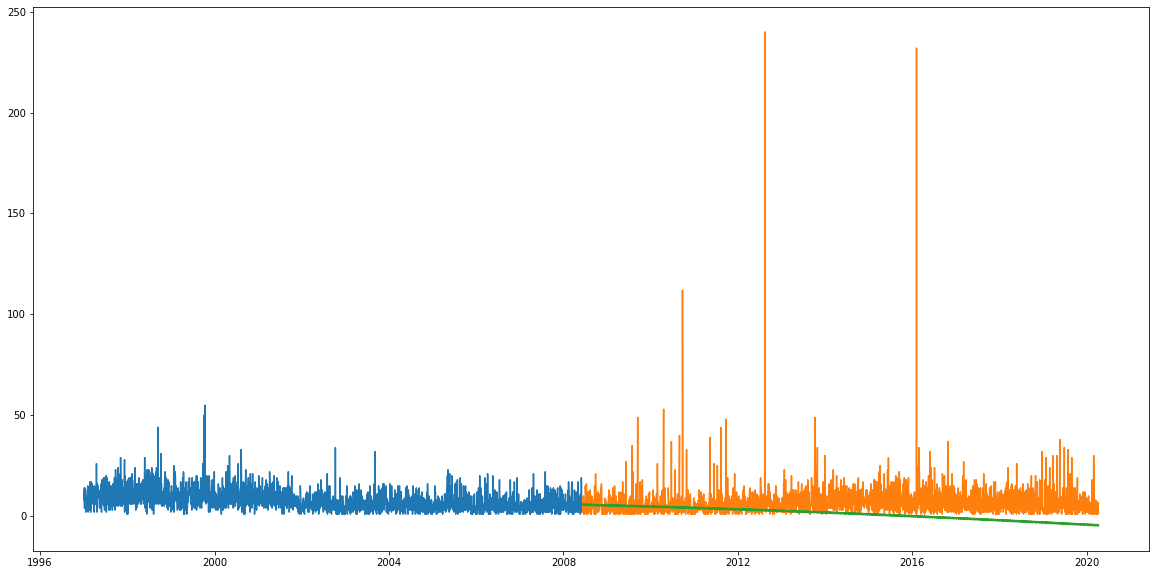

In [348]:
#plot
plt.plot(train)
plt.plot(valid)
plt.plot(forecast['Prediction'])

In [349]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(evictedByDay)),columns=['Date', 'Evicted'])

for i in range(0,len(evictedByDay)):
    new_data['Date'][i] = evictedByDay.index[i]
    new_data['Evicted'][i] = evictedByDay[i]

new_data['Date'] = pd.to_datetime(new_data["Date"])
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Evicted': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:halfway_point]
valid = new_data[halfway_point:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [350]:
#rmse
forecast_valid = forecast['yhat'][halfway_point:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

9.035081975321464

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


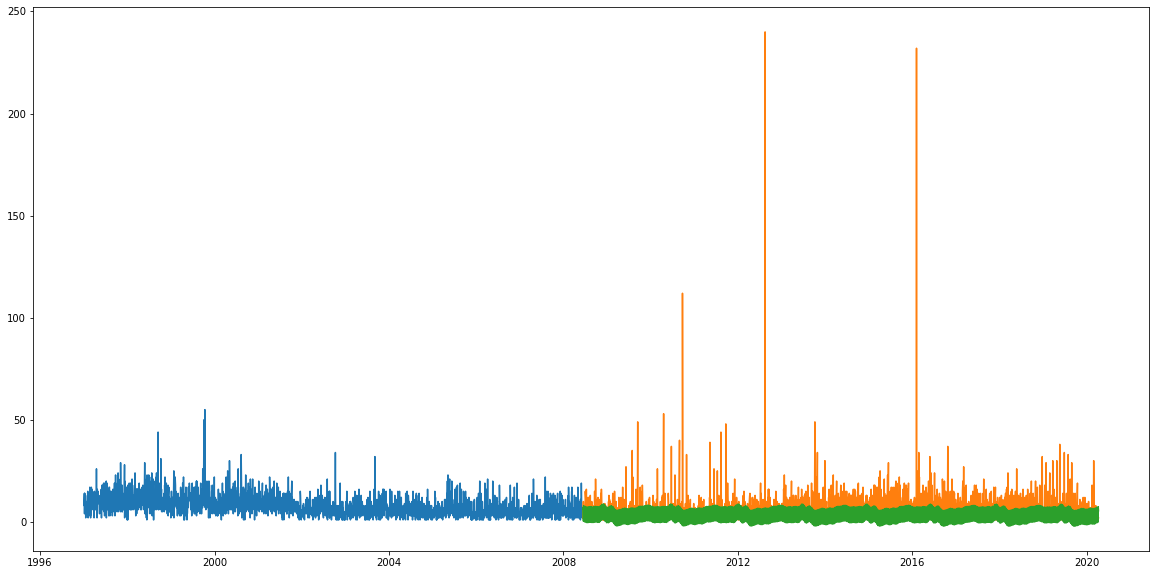

In [351]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [352]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = evictedByDay.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(evictedByDay)),columns=['Date', 'Evicted'])
for i in range(0,len(data)):
    new_data['Date'][i] = evictedByDay.index[i]
    new_data['Evicted'][i] = evictedByDay[i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:halfway_point,:]
valid = dataset[halfway_point:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(40,len(train)):
    x_train.append(scaled_data[i-40:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 40:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(40,inputs.shape[0]):
    X_test.append(inputs[i-40:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 59s - loss: 4.3359e-04


In [353]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

8.186872995016497

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


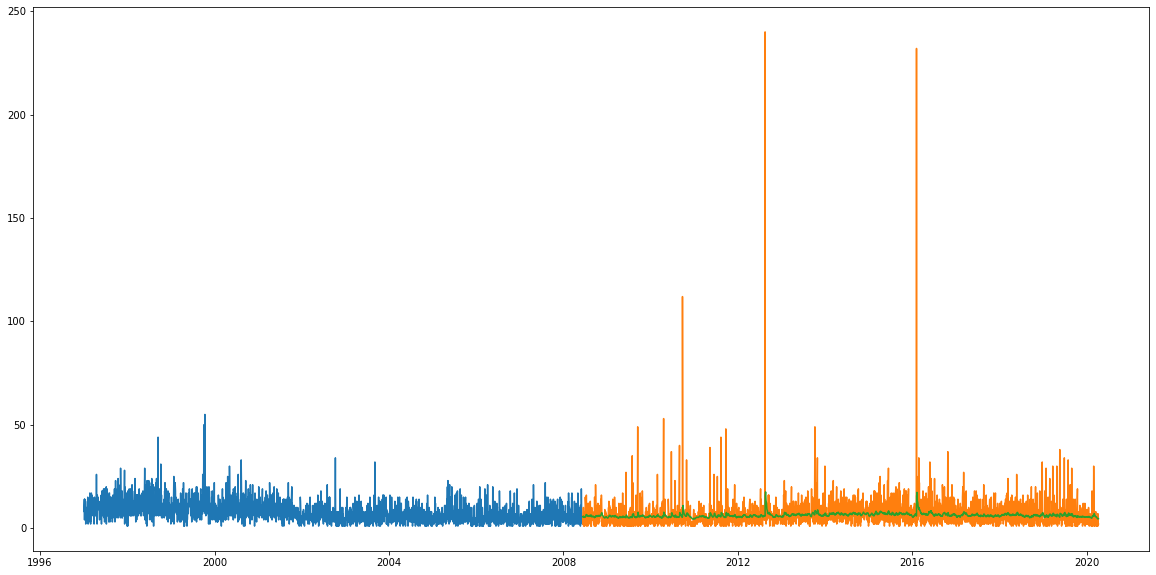

In [354]:
#for plotting
train = new_data[:halfway_point]
valid = new_data[halfway_point:]
valid['Predictions'] = closing_price
plt.plot(train['Evicted'])
plt.plot(valid[['Evicted','Predictions']])